In [1]:
#import relevant packages
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,RocCurveDisplay
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

import itertools
from collections import Counter
import re

from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D # convolution layer
from tensorflow.keras.layers import MaxPooling2D # max pooling layer

from PIL import Image
import os

In [2]:
#set a seed to use for random_state inputs for reproducability
SEED = 42

## Import Data

In [3]:
#Please refer to the 'Audio_Pull' notebook to see how dataset was compiled from the public AudioSet data 
#and how audio clips were downloaded
#Please refer to the 'Spectrogram_Build' notebook to see how spectrograms were created
#Please refer to 'Feature_Extraction' notebook to see how 

In [4]:
#In downloading audio and creating spectrograms, some files resulted in an empty audio file and blank, white spetrogram
#This function is designed to filter out any empyty/blank data points
def is_blank_image(image, threshold=0.99):
    # Convert the image to a NumPy array
    image_array = np.array(image)
    # Calculate the mean pixel value
    mean_pixel_value = np.mean(image_array)
    # Check if the mean pixel value is below the threshold
    return mean_pixel_value > threshold



In [5]:
#Import images
image_folder_128 = 'spectrograms-128'
image_files = [file for file in os.listdir(image_folder_128) if file.lower().endswith(('.png'))]


genres = []
images = []

for file in image_files:
    image = Image.open(os.path.join(image_folder_128, file)).resize((64, 64))
    image = np.array(image) / 255
    
    # Check if the image is mostly blank and skip it if it is
    if not is_blank_image(image):
        images.append(image)
        # Extract genre label from the file name
        genre_label = file.split('_')[0]
        genres.append(genre_label)

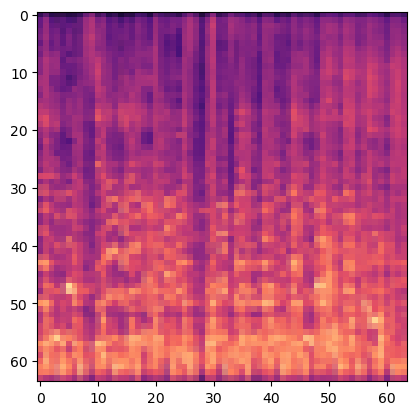

In [6]:
plt.imshow(images[100])

In [7]:
len(genres)

14961

In [8]:
len(images)

14961

In [9]:
genres_df = pd.DataFrame(genres)
genres_df[0].value_counts()

0
Rock       2744
Pop        2739
Country    2479
EDM        2467
Hip-Hop    2427
Reggae     2105
Name: count, dtype: int64

## Preprocessing

In [10]:
#train_test split data
X_train, X_test, y_train, y_test = train_test_split(images, genres, test_size=0.2, stratify=genres, random_state=SEED)

In [11]:
#one hot encode genre labels for train
genre_labels_unique = list(set(genres))
label_to_index = {label: index for index, label in enumerate(genre_labels_unique)}
y_train_num_labels = [label_to_index[label] for label in y_train]
y_train_one_hot = to_categorical(y_train_num_labels)

In [12]:
#one hot encode genre labels for test
y_test_num_labels = [label_to_index[label] for label in y_test]
y_test_one_hot = to_categorical(y_test_num_labels)

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [14]:
np.shape(X_train)

(11968, 64, 64, 4)

In [15]:
np.shape(y_train_one_hot)

(11968, 6)

## Modeling

### Baseline CNN

In [16]:
model = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
# COv2D input shape =(image_height, image_width, color_channels) for each image
model.add(Conv2D(filters=32,
                        kernel_size=(4, 4),
                        activation='relu',
                        input_shape=(64, 64, 4)))
# max pool in 2x2 window
model.add(MaxPooling2D(pool_size=(2, 2)))

# transition to dense fully-connected part of network
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [18]:
history = model.fit(X_train, y_train_one_hot, epochs= 20, batch_size=32, verbose = 2, validation_split=.2)

Epoch 1/20
300/300 - 6s - loss: 1.7127 - accuracy: 0.2914 - val_loss: 1.5897 - val_accuracy: 0.3576 - 6s/epoch - 19ms/step
Epoch 2/20
300/300 - 4s - loss: 1.5434 - accuracy: 0.3742 - val_loss: 1.5521 - val_accuracy: 0.3642 - 4s/epoch - 14ms/step
Epoch 3/20
300/300 - 4s - loss: 1.4815 - accuracy: 0.4039 - val_loss: 1.4869 - val_accuracy: 0.4002 - 4s/epoch - 13ms/step
Epoch 4/20
300/300 - 4s - loss: 1.4411 - accuracy: 0.4242 - val_loss: 1.5103 - val_accuracy: 0.3960 - 4s/epoch - 13ms/step
Epoch 5/20
300/300 - 4s - loss: 1.4100 - accuracy: 0.4419 - val_loss: 1.4339 - val_accuracy: 0.4265 - 4s/epoch - 13ms/step
Epoch 6/20
300/300 - 4s - loss: 1.3649 - accuracy: 0.4715 - val_loss: 1.4440 - val_accuracy: 0.4432 - 4s/epoch - 14ms/step
Epoch 7/20
300/300 - 4s - loss: 1.3395 - accuracy: 0.4826 - val_loss: 1.4248 - val_accuracy: 0.4557 - 4s/epoch - 14ms/step
Epoch 8/20
300/300 - 4s - loss: 1.3051 - accuracy: 0.4958 - val_loss: 1.3936 - val_accuracy: 0.4720 - 4s/epoch - 14ms/step
Epoch 9/20
300/3

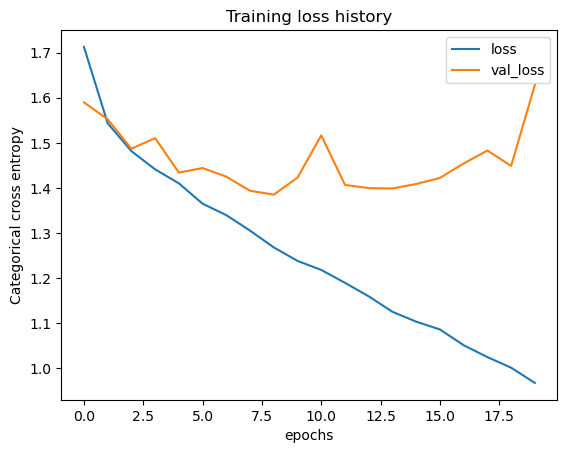

In [19]:
train_history = pd.DataFrame(history.history)
train_history.index.name = 'epochs'

col_list = ['loss', 'val_loss']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training loss history')
plt.show()

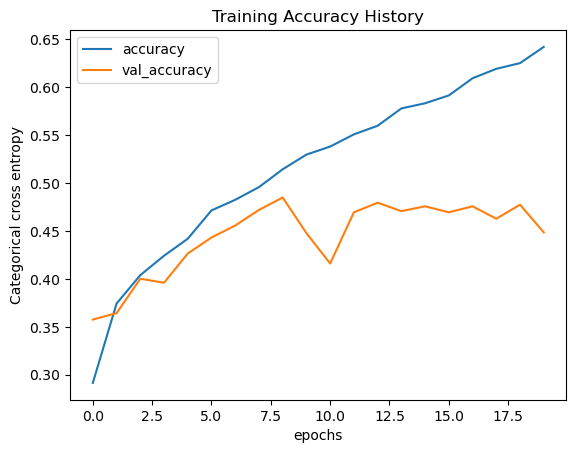

In [20]:
train_history = pd.DataFrame(history.history)
train_history.index.name = 'epochs'

col_list = ['accuracy', 'val_accuracy']
train_history[col_list].plot()
plt.ylabel('Categorical cross entropy')
plt.title('Training Accuracy History')
plt.show()

### Tuned CNN

In [21]:
model02 = Sequential()
# define 3x3 filter window sizes. Create 32 filters.
# COv2D layer one
model02.add(Conv2D(filters=32,
                        kernel_size=(4, 4),
                        activation='relu',
                        input_shape=(64, 64, 4)))
# max pool lay one
model02.add(MaxPooling2D(pool_size=(2, 2)))

# COv2D layer two
model02.add(Conv2D(filters=32,
                        kernel_size=(4, 4),
                        activation='relu',
                        input_shape=(64, 64, 4)))
# max pool lay two
model02.add(MaxPooling2D(pool_size=(2, 2)))

# transition to dense fully-connected part of network
model02.add(Flatten())
model02.add(Dense(64, activation='relu'))
model02.add(Dense(6, activation='softmax'))

In [22]:
model02.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['accuracy'])

In [23]:
history02 = model02.fit(X_train, y_train_one_hot, epochs= 20, batch_size=32, verbose = 2, validation_split=.2)

Epoch 1/20
300/300 - 8s - loss: 1.6914 - accuracy: 0.2810 - val_loss: 1.6362 - val_accuracy: 0.3187 - 8s/epoch - 27ms/step
Epoch 2/20
300/300 - 8s - loss: 1.5594 - accuracy: 0.3638 - val_loss: 1.5725 - val_accuracy: 0.3605 - 8s/epoch - 26ms/step
Epoch 3/20
300/300 - 7s - loss: 1.5043 - accuracy: 0.3890 - val_loss: 1.5503 - val_accuracy: 0.3739 - 7s/epoch - 24ms/step
Epoch 4/20
300/300 - 47s - loss: 1.4838 - accuracy: 0.4056 - val_loss: 1.5294 - val_accuracy: 0.3693 - 47s/epoch - 157ms/step
Epoch 5/20
300/300 - 8s - loss: 1.4717 - accuracy: 0.4033 - val_loss: 1.5162 - val_accuracy: 0.3910 - 8s/epoch - 28ms/step
Epoch 6/20
300/300 - 7s - loss: 1.4515 - accuracy: 0.4157 - val_loss: 1.4838 - val_accuracy: 0.4165 - 7s/epoch - 24ms/step
Epoch 7/20
300/300 - 7s - loss: 1.4302 - accuracy: 0.4288 - val_loss: 1.4944 - val_accuracy: 0.3981 - 7s/epoch - 23ms/step
Epoch 8/20
300/300 - 7s - loss: 1.4091 - accuracy: 0.4375 - val_loss: 1.4815 - val_accuracy: 0.4077 - 7s/epoch - 24ms/step
Epoch 9/20
30

## Modeling